In [1]:
import pandas as pd
import numpy as np
import itertools

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

#statistics libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from scipy.stats import anderson
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, seasonal_plot, plot_acf, plot_pacf, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.statespace.tools import diff as diff
import pmdarima as pm
from pmdarima import ARIMA, auto_arima
from scipy import signal
from scipy.stats import shapiro
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings("ignore")

In [2]:
gold = pd.read_excel('gold.xls')
gold

,Date,Gold
0,1994-01-01,137.31491
1,1994-02-01,136.52517
2,1994-03-01,133.95854
3,1994-04-01,134.74827
4,1994-05-01,133.46496
...,...,...
347,2022-12-01,617.17670
348,2023-01-01,638.79566
349,2023-02-01,662.68509
350,2023-03-01,634.15597


In [3]:
gold['Date'] = pd.to_datetime(gold['Date'])
gold.set_index('Date', inplace=True)

In [4]:
gold.head()

,Gold
Date,
1994-01-01,137.31491
1994-02-01,136.52517
1994-03-01,133.95854
1994-04-01,134.74827
1994-05-01,133.46496


## Time Series Plot

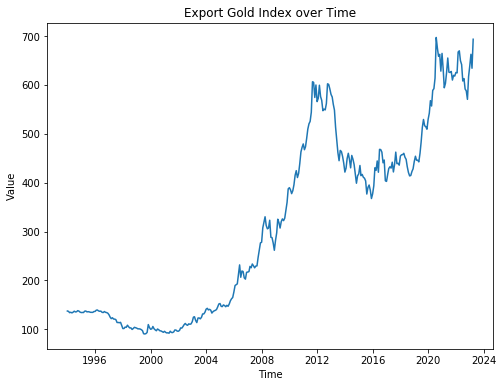

In [64]:
plt.figure(figsize=(8,6))
plt.plot(gold['Gold'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Export Gold Index over Time')
plt.show()

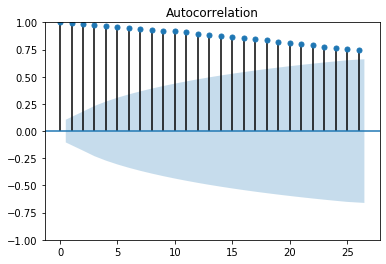

In [6]:
plot_acf(gold['Gold']);

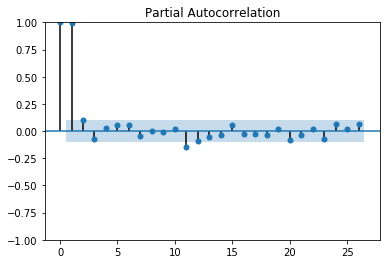

In [7]:
plot_pacf(gold['Gold']);

## STL decomposition

Text(0.5, 0.98, 'Additive Decomposition')

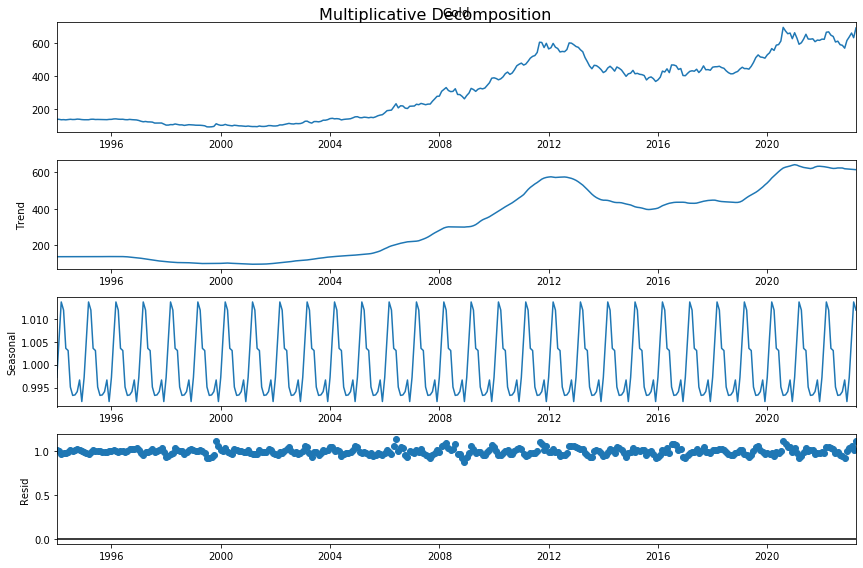

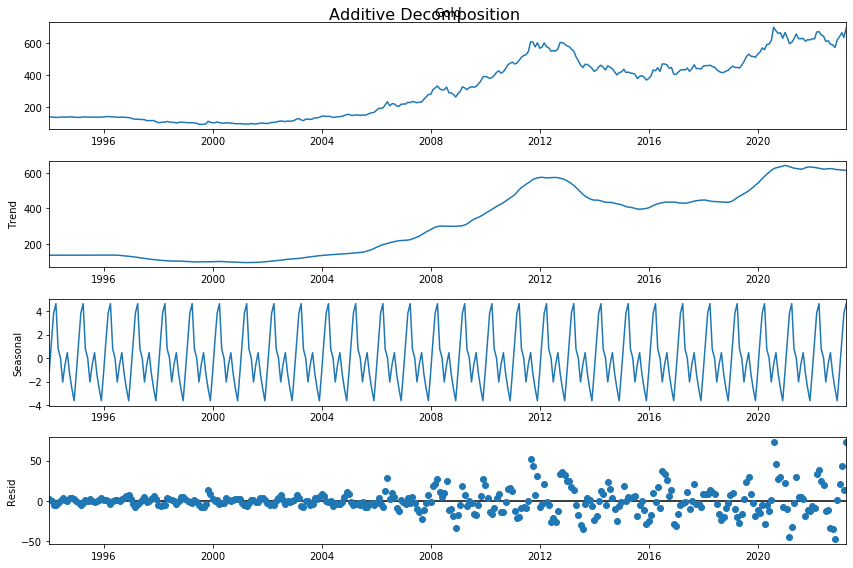

In [8]:
# Multiplicative Decomposition
decomposeM = seasonal_decompose(gold["Gold"],model='multiplicative', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeM.plot();
decomposeM.plot().suptitle('Multiplicative Decomposition', fontsize=16)

# Additive Decomposition
decomposeA = seasonal_decompose(gold["Gold"],model='additive', extrapolate_trend='freq')
plt.rcParams['figure.figsize'] = (12, 8);
#decomposeA.plot();
decomposeA.plot().suptitle('Additive Decomposition', fontsize=16)

In [9]:
ljung_p = np.mean(ljung(x=decomposeA.resid.dropna())['lb_pvalue'])
ljung_p = round(ljung_p, 3)
print("Ljung Box (A), p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box (A), p value: 0.0 , Residuals are correlated


In [10]:
ljung_p = np.mean(ljung(x=decomposeM.resid.dropna())['lb_pvalue'])
ljung_p = round(ljung_p, 3)
print("Ljung Box (A), p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box (A), p value: 0.0 , Residuals are correlated


## ETS

In [11]:
train = gold.iloc[:340]
test  = gold.iloc[340:]
predictions = test.copy()

In [12]:
model = sm.tsa.ExponentialSmoothing(train['Gold'], trend='add', seasonal='add').fit()
forecast_ets_used = model.forecast(steps=12)

In [13]:
train = train.set_index(pd.DatetimeIndex(train.index, freq='MS'))

In [14]:
ets_model=sm.tsa.statespace.ExponentialSmoothing(train["Gold"], #driver of everything
                                           trend=True, # includes å and ß
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=False).fit()
                                           #default holt winters model

fc_model = ets_model.forecast(12) #inverting the Log

predictions["ETS"]=fc_model

In [15]:
ets_model.summary()
# (A,A,A) holt winters default

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                   Gold   No. Observations:                  340
Model:                   ETS(A, A, A)   Log Likelihood               -1381.984
Date:                Wed, 07 Jun 2023   AIC                           2771.968
Time:                        15:13:46   BIC                           2787.284
Sample:                    01-01-1994   HQIC                          2778.070
                         - 04-01-2022   Scale                          198.629
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9997      0.040     25.036      0.000       0.921       1.078
smoothing_trend        0.0078      0.005      1.480      0.139      -0.003       0.018
smoothing_seasonal     0.0001      0.020      0.005      0.996      -0.039       0.039
=============================================
             initialization method: heuristic
---------------------------------------------
level                                135.4522
trend                                  0.0352
seasonal                              -0.0609
seasonal.L1                            1.3406
seasonal.L2                            0.9550
seasonal.L3                            0.3021
seasonal.L4                           -0.7643
seasonal.L5                            0.5704
seasonal.L6                            0.8244
seasonal.L7                            1.3561
seasonal.L8                            0.2599
seasonal.L9                           -1.0409
seasonal.L10                          -1.7823
seasonal.L11                          -1.9602
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               322.10
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):              39.98   Skew:                             0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

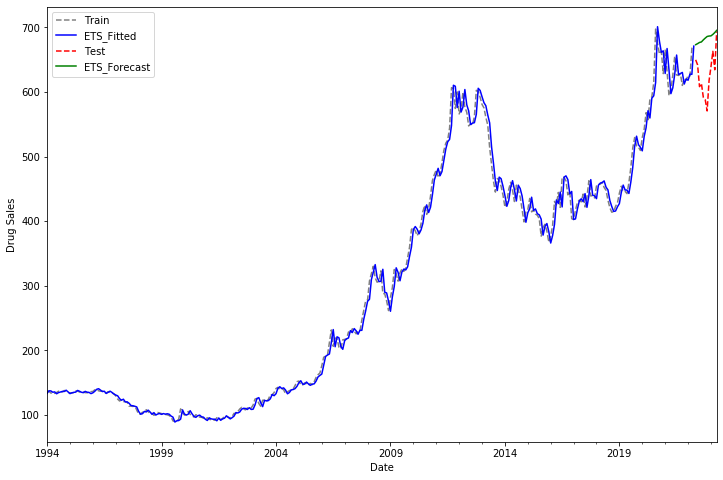

In [16]:
train["Gold"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
ets_model.fittedvalues.plot(color="b", legend=True, label="ETS_Fitted")
predictions["Gold"].plot(style="--",color="r", legend=True, label="Test")
plt.xlabel('Time')
plt.ylabel('Drug Sales')
predictions["ETS"].plot(color="g", legend=True, label="ETS_Forecast")

In [18]:
ets_errors = predictions["ETS"] - predictions["Gold"]
ets_rmse = np.sqrt(np.mean(ets_errors ** 2))
ets_mape = np.mean(np.abs(ets_errors / predictions["Gold"])) * 100
print("ETS RMSE:", ets_rmse)
print("ETS MAPE:", ets_mape)

ETS RMSE: 65.66470423289408
ETS MAPE: 9.486371438639301


In [19]:
ets_model_damp=sm.tsa.statespace.ExponentialSmoothing(train["Gold"], #driver of everything
                                           trend=True, # includes å and ß
                                           initialization_method= 'heuristic', 
                                           seasonal=12, 
                                           damped_trend=True).fit()
                                           #default holt winters model

fc_model_damp = ets_model_damp.forecast(12) #inverting the Log

predictions["ETS_damp"]=fc_model_damp

In [20]:
ets_model_damp.summary()
# (A,A,A) holt winters default

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Exponential Smoothing Results                         
==============================================================================
Dep. Variable:                   Gold   No. Observations:                  340
Model:                  ETS(A, Ad, A)   Log Likelihood               -1381.410
Date:                Wed, 07 Jun 2023   AIC                           2772.820
Time:                        15:14:03   BIC                           2791.965
Sample:                    01-01-1994   HQIC                          2780.449
                         - 04-01-2022   Scale                          197.960
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.044     22.905      0.000       0.914       1.085
smoothing_trend        0.0306      0.020      1.530      0.126      -0.009       0.070
smoothing_seasonal     0.0001      0.020      0.005      0.996      -0.038       0.039
damping_trend          0.9628      0.043     22.582      0.000       0.879       1.046
=============================================
             initialization method: heuristic
---------------------------------------------
level                                135.4522
trend                                  0.0352
seasonal                              -0.0609
seasonal.L1                            1.3406
seasonal.L2                            0.9550
seasonal.L3                            0.3021
seasonal.L4                           -0.7643
seasonal.L5                            0.5704
seasonal.L6                            0.8244
seasonal.L7                            1.3561
seasonal.L8                            0.2599
seasonal.L9                           -1.0409
seasonal.L10                          -1.7823
seasonal.L11                          -1.9602
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               301.87
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):              39.90   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

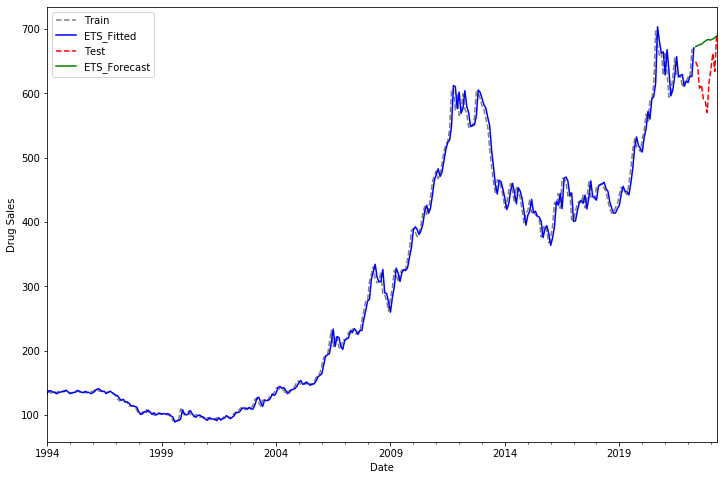

In [21]:
train["Gold"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
ets_model_damp.fittedvalues.plot(color="b", legend=True, label="ETS_Fitted")
predictions["Gold"].plot(style="--",color="r", legend=True, label="Test")
plt.xlabel('Time')
plt.ylabel('Drug Sales')
predictions["ETS_damp"].plot(color="g", legend=True, label="ETS_Forecast")

In [22]:
ets_damp_errors = predictions["ETS_damp"] - predictions["Gold"]
ets_damp_rmse = np.sqrt(np.mean(ets_damp_errors ** 2))
ets_damp_mape = np.mean(np.abs(ets_damp_errors / predictions["Gold"])) * 100
print("ETS with Damp Trend RMSE:", ets_damp_rmse)
print("ETS with Damp Trend MAPE:", ets_damp_mape)

ETS with Damp Trend RMSE: 63.95712682419882
ETS with Damp Trend MAPE: 9.219523532694428


## Holt-Winters

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES #also uses exponential smoothing

In [51]:
hw_model = HWES(train, seasonal_periods=12, trend='add', seasonal='add')
hw_fitted = hw_model.fit()

In [52]:
print(hw_fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                     Gold   No. Observations:                  340
Model:             ExponentialSmoothing   SSE                          65831.077
Optimized:                         True   AIC                           1822.407
Trend:                         Additive   BIC                           1883.670
Seasonal:                      Additive   AICC                          1824.537
Seasonal Periods:                    12   Date:                 Wed, 07 Jun 2023
Box-Cox:                          False   Time:                         15:19:23
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9999979                alpha                 True
smoothing_trend          

when alpha = 1, all weight on today's value. Here alpha is extremely close to 1, so past value is not that important.

not much change in the slope(pretty linear), so beta is small

gamma: weight attached with G (?)

In [53]:
forecast_hw = hw_fitted.forecast(steps=12)
predictions["HW"]=forecast_hw

In [54]:
forecast_hw

2022-05-01    670.377778
2022-06-01    671.243983
2022-07-01    671.940201
2022-08-01    674.766698
2022-09-01    678.057153
2022-10-01    677.867284
2022-11-01    678.549930
2022-12-01    677.376633
2023-01-01    680.408604
2023-02-01    683.885433
2023-03-01    688.326360
2023-04-01    688.460073
Freq: MS, dtype: float64

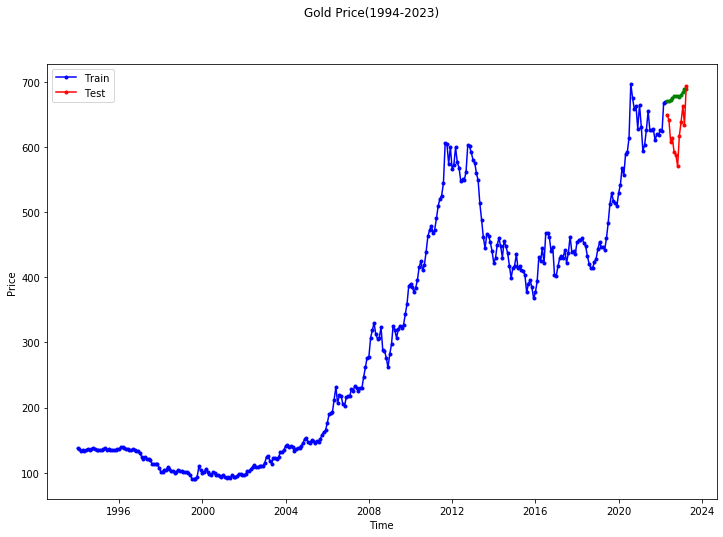

In [55]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Gold Price(1994-2023)')
past, = plt.plot(train.index, train["Gold"], 'b.-', label='Train')
predicted_future, = plt.plot(test.index, forecast_hw, 'g.-', label='HW_Forecast')
future, = plt.plot(test.index, test, 'r.-', label='Test')
plt.legend(handles=[past, future])
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [62]:
hw_errors = predictions["HW"] - predictions["Gold"]
hw_rmse = np.sqrt(np.mean(hw_errors ** 2))
hw_mape = np.mean(np.abs(hw_errors / predictions["Gold"])) * 100
print("Holt-Winters RMSE:", hw_rmse)
print("Holt-Winters MAPE:", hw_mape)

Holt-Winters RMSE: 61.38303395191589
Holt-Winters MAPE: 8.832263603336349
